In [1]:
## Load the LabOne API and other necessary packages
from zhinst.toolkit import Session, CommandTable

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

### connect to data server
session = Session(SERVER_HOST)

### connect to device
device = session.connect_device(DEVICE_ID)


In [2]:
session

DataServerSession(localhost:8004)

In [355]:
SG_CHAN_INDEX = 5 # which channel to be used, here: first channel

##determine which synthesizer is used by the desired channel
synth = device.sgchannels[SG_CHAN_INDEX].synthesizer()

with device.set_transaction():
    # RF output settings
    device.sgchannels[SG_CHAN_INDEX].output.range(10) #output range in dBm
    device.sgchannels[SG_CHAN_INDEX].output.rflfpath(0) #use RF path, not LF path
    device.synthesizers[synth].centerfreq(1e9) #set the corresponding synthesizer frequency in Hz
    device.sgchannels[SG_CHAN_INDEX].output.on(1) #enable output
    # Digital modulation settings
    device.sgchannels[SG_CHAN_INDEX].awg.outputamplitude(1.0) #set the amplitude for the AWG outputs
    device.sgchannels[SG_CHAN_INDEX].oscs[0].freq(100.0e6) #frequency of oscillator 1 in Hz
    device.sgchannels[SG_CHAN_INDEX].oscs[1].freq(-150.0e6) #frequency of oscillator 2 in Hz
    device.sgchannels[SG_CHAN_INDEX].awg.modulation.enable(1) #enable digital modulation
    # Triggering settings
    device.sgchannels[SG_CHAN_INDEX].marker.source(0) #AWG trigger 1

In [36]:
seqc_program = """\
// Define waveform
wave w_a = gauss(2048, 1, 1024, 256);

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_a, 0);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
setTrigger(1);
setTrigger(0);

// execute the first command table entry
executeTableEntry(0);
// execute the second command table entry
executeTableEntry(1);
"""

## Upload sequence
device.sgchannels[SG_CHAN_INDEX].awg.load_sequencer_program(seqc_program)

{'messages': '', 'maxelfsize': 2147483648}

In [37]:
## Load CommandTable class
from zhinst.toolkit import CommandTable

## Initialize command table
ct_schema = device.sgchannels[SG_CHAN_INDEX].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

## Index of wave table and command table entries
TABLE_INDEX = 0
WAVE_INDEX = 0
gain = 1.0

# match amplitudeXX to "Digital Modulation" Output Gains

## Waveform with amplitude and phase settings
ct.table[TABLE_INDEX].waveform.index = WAVE_INDEX
ct.table[TABLE_INDEX].amplitude00.value = gain
ct.table[TABLE_INDEX].amplitude01.value = -gain
ct.table[TABLE_INDEX].amplitude10.value = gain
ct.table[TABLE_INDEX].amplitude11.value = gain
ct.table[TABLE_INDEX].phase.value = 0

## Same waveform with different amplitude and phase settings
ct.table[TABLE_INDEX+1].waveform.index = WAVE_INDEX
ct.table[TABLE_INDEX+1].amplitude00.value = gain/2
ct.table[TABLE_INDEX+1].amplitude01.value = -gain/2
ct.table[TABLE_INDEX+1].amplitude10.value = gain/2
ct.table[TABLE_INDEX+1].amplitude11.value = gain/2
ct.table[TABLE_INDEX+1].phase.value = 180

ct.as_dict()

{'header': {'version': '1.4.0'},
 'table': [{'index': 0,
   'waveform': {'index': 0},
   'amplitude00': {'value': 1.0},
   'amplitude01': {'value': -1.0},
   'amplitude10': {'value': 1.0},
   'amplitude11': {'value': 1.0},
   'phase': {'value': 0}},
  {'index': 1,
   'waveform': {'index': 0},
   'amplitude00': {'value': 0.5},
   'amplitude01': {'value': -0.5},
   'amplitude10': {'value': 0.5},
   'amplitude11': {'value': 0.5},
   'phase': {'value': 180}}]}

In [38]:
## Upload command table
device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)

In [45]:
# run the sequence
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = True)

# saved as 1

## Efficient pulse incrementation

In [53]:
seqc_program = """\
// Define a single waveform
wave w_a = ones(1024);

// Assign a single channel waveform to wave table entry
assignWaveIndex(1,2, w_a, 0);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
setTrigger(1);
setTrigger(0);

// execute the first command table entry
executeTableEntry(0);
repeat(20) {
  executeTableEntry(1);
}
"""

## Upload sequence
device.sgchannels[SG_CHAN_INDEX].awg.load_sequencer_program(seqc_program)

{'messages': '', 'maxelfsize': 2147483648}

In [54]:
## Initialize command table
ct_schema = device.sgchannels[SG_CHAN_INDEX].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

## Waveform with initial amplitude
ct.table[0].waveform.index = 0
ct.table[0].amplitude00.value = 0
ct.table[0].amplitude01.value = 0
ct.table[0].amplitude10.value = 0
ct.table[0].amplitude11.value = 0

## Waveform with incremented amplitude
ct.table[1].waveform.index = 0
ct.table[1].amplitude00.value = 0.05
ct.table[1].amplitude01.value = -0.05
ct.table[1].amplitude10.value = 0.05
ct.table[1].amplitude11.value = 0.05
ct.table[1].amplitude00.increment = True
ct.table[1].amplitude01.increment = True
ct.table[1].amplitude10.increment = True
ct.table[1].amplitude11.increment = True

## Upload command table
device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)


In [56]:
## Enable sequencer
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = 1)  # runs the experiment
# saved as 2.png

### Basic sweeps

In [66]:
seqc_program = """\
//Constant definitions
const readout = 512; //length of readout in samples

//Waveform definition
wave wI1 = gauss(128, 1, 64, 16);
wave wI2 = gauss(256, 1, 128, 32);

//Assign index and outputs
assignWaveIndex(1,2,wI1,0);
assignWaveIndex(1,2,wI2,1);

// Trigger the scope
setTrigger(1);
setTrigger(0);

var i = 10;
executeTableEntry(0);
do {
  executeTableEntry(2);
  executeTableEntry(1);
  playZero(readout);
  i-=1;
} while(i);
"""

# Upload sequence
device.sgchannels[SG_CHAN_INDEX].awg.load_sequencer_program(seqc_program)

{'messages': '', 'maxelfsize': 2147483648}

readout is just a delay with nothing being played

In [67]:
# Initialize command table
ct_schema = device.sgchannels[0].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

# Initialize amplitude register 1
ct.table[0].amplitude00.value = 0.0
ct.table[0].amplitude00.increment = False
ct.table[0].amplitude10.value = 0.0
ct.table[0].amplitude10.increment = False
ct.table[0].amplitudeRegister = 1

# Swept Gaussian pulse
ct.table[1].waveform.index = 1
ct.table[1].amplitude00.value = 0.05
ct.table[1].amplitude00.increment = True
ct.table[1].amplitude10.value = 0.05
ct.table[1].amplitude10.increment = True
ct.table[1].amplitudeRegister = 1

# Constant Gaussian pulse
ct.table[2].waveform.index = 0
ct.table[2].amplitude00.value = 0.9
ct.table[2].amplitude10.value = 0.9
ct.table[2].amplitudeRegister = 0

# Upload command table
device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)

In [69]:
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = 1)
# saved as 3.png

In [70]:
# do a phase sweep instead
## Define command table
## Initialize command table
ct_schema = device.sgchannels[SG_CHAN_INDEX].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

## Waveform with initial phase
ct.table[0].waveform.index = 0
ct.table[0].phase.value = 90

## Waveform with incremented phase
ct.table[1].waveform.index = 0
ct.table[1].phase.value = 0.1
ct.table[1].phase.increment = True

## Upload command table
device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)
## Enable sequencer
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = 1)

this isn't quite as noticable as the phase difference is minimal

## pulse-level sequencing

In [71]:
seqc_program = """\
// Define two wave table entries through placeholders
assignWaveIndex(1,2, placeholder(32), 0);
assignWaveIndex(1,2, placeholder(64), 1);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
setTrigger(1);
setTrigger(0);

// execute command table
executeTableEntry(0);
executeTableEntry(1);
executeTableEntry(2);
"""

## Upload sequence
device.sgchannels[SG_CHAN_INDEX].awg.load_sequencer_program(seqc_program)

{'messages': '', 'maxelfsize': 2147483648}

In [72]:
import numpy as np
from zhinst.toolkit import Waveforms

## parameters for waveform generation
amp_1 = 1
length_1 = 32
width_1 = 1/4
amp_2 = 1
length_2 = 64
width_2 = 1/4
x_1 = np.linspace(-1, 1, length_1)
x_2 = np.linspace(-1, 1, length_2)

## define waveforms as list of real-values arrays - here: Gaussian functions
waves = [
    [amp_1*np.exp(-x_1**2/width_1**2)],
    [amp_2*np.exp(-x_2**2/width_2**2)]]

## upload waveforms to instrument
waveforms = Waveforms()
for i, wave in enumerate(waves):
    waveforms[i] = (wave[0])

device.sgchannels[SG_CHAN_INDEX].awg.write_to_waveform_memory(waveforms)

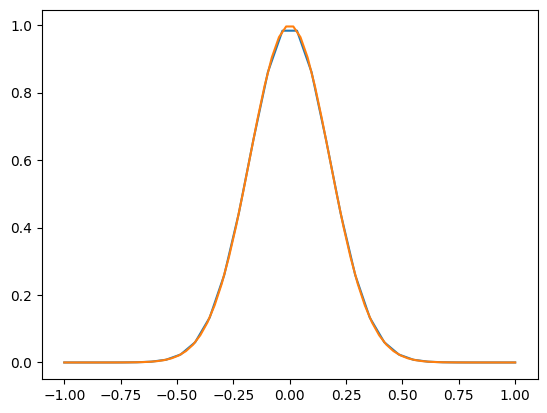

In [76]:
import matplotlib.pyplot as plt

plt.plot(x_1, waves[0][0])
plt.plot(x_2, waves[1][0])

In [77]:
## Define command table
## Initialize command table
ct_schema = device.sgchannels[SG_CHAN_INDEX].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

## Waveform 0 with oscillator 1
ct.table[0].waveform.index = 0
ct.table[0].amplitude00.value = 1.0
ct.table[0].amplitude01.value = -1.0
ct.table[0].amplitude10.value = 1.0
ct.table[0].amplitude11.value = 1.0
ct.table[0].phase.value = 0.0
ct.table[0].oscillatorSelect.value = 0

## Waveform 1 with oscillator 2
ct.table[1].waveform.index = 0
ct.table[1].amplitude00.value = 1.0
ct.table[1].amplitude01.value = -1.0
ct.table[1].amplitude10.value = 1.0
ct.table[1].amplitude11.value = 1.0
ct.table[1].phase.value = 0.0
ct.table[1].oscillatorSelect.value = 1

## Waveform 1 with oscillator 1 and different phase
ct.table[2].waveform.index = 0
ct.table[2].amplitude00.value = 1.0
ct.table[2].amplitude01.value = -1.0
ct.table[2].amplitude10.value = 1.0
ct.table[2].amplitude11.value = 1.0
ct.table[2].phase.value = 90.0
ct.table[2].oscillatorSelect.value = 0

## Upload command table
device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)


In [87]:
## Enable sequencer
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = 1)
# saved as 4.png

# Our sweeps


## Simple square pulse

In [359]:
SG_CHAN_INDEX = 5 # which channel to be used, here: first channel

##determine which synthesizer is used by the desired channel
synth = device.sgchannels[SG_CHAN_INDEX].synthesizer()

with device.set_transaction():
    # RF output settings
    device.sgchannels[SG_CHAN_INDEX].output.range(10) #output range in dBm
    device.sgchannels[SG_CHAN_INDEX].output.rflfpath(0) #use RF path, not LF path
    device.synthesizers[synth].centerfreq(0) #set the corresponding synthesizer frequency in Hz
    device.sgchannels[SG_CHAN_INDEX].output.on(1) #enable output
    # Digital modulation settings
    device.sgchannels[SG_CHAN_INDEX].awg.outputamplitude(1.0) #set the amplitude for the AWG outputs
    device.sgchannels[SG_CHAN_INDEX].oscs[0].freq(0) #frequency of oscillator 1 in Hz
    device.sgchannels[SG_CHAN_INDEX].oscs[1].freq(0) #frequency of oscillator 2 in Hz
    device.sgchannels[SG_CHAN_INDEX].awg.modulation.enable(1) #enable digital modulation
    # Triggering settings
    device.sgchannels[SG_CHAN_INDEX].marker.source(0) #AWG trigger 1

In [161]:
# define the waveform
from zhinst.toolkit.waveform import Wave

wave01 = Wave(np.ones(1024), name="demo")

waveforms = Waveforms()
waveforms.assign_waveform(
    slot= 0, # index in assignWaveIndex
    wave1= wave01,
    wave2= wave01,
)

# Before upload get sequence code
print(waveforms.get_sequence_snippet())

wave demo = placeholder(1024, false, false);
wave demo = placeholder(1024, false, false);
assignWaveIndex(demo, demo, 0);


In [162]:
from zhinst.toolkit import Sequence

seq = Sequence()

seq.waveforms = waveforms
seq.code = """\
// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
setTrigger(1);
setTrigger(0);

// execute the first command table entry
executeTableEntry(0);
playZero(1024);
// execute the second command table entry
executeTableEntry(1);
"""

print(seq)

## Upload sequence
device.sgchannels[SG_CHAN_INDEX].awg.load_sequencer_program(seqc_program)

// Waveforms declaration
wave demo = placeholder(1024, false, false);
wave demo = placeholder(1024, false, false);
assignWaveIndex(demo, demo, 0);
// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
setTrigger(1);
setTrigger(0);

// execute the first command table entry
executeTableEntry(0);
playZero(1024);
// execute the second command table entry
executeTableEntry(1);



{'messages': '', 'maxelfsize': 2147483648}

In [188]:
## Initialize command table
ct_schema = device.sgchannels[SG_CHAN_INDEX].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

## Index of wave table and command table entries
TABLE_INDEX = 0
WAVE_INDEX = 0
gain = 1.0

# match amplitudeXX to "Digital Modulation" Output Gains

# Initialize amplitude register 1
ct.table[0].amplitude00.value = 0.0
ct.table[0].amplitude00.increment = False
ct.table[0].amplitude10.value = 0.0
ct.table[0].amplitude10.increment = False
ct.table[0].amplitudeRegister = 1
ct.table[0].amplitude01.value = 0.0
ct.table[0].amplitude11.value = 0.0
#ct.table[0].waveform.length = 10240
#ct.table[0].waveform.playHold = True

## Same waveform with different amplitude and phase settings
ct.table[TABLE_INDEX+1].waveform.index = WAVE_INDEX
ct.table[TABLE_INDEX+1].amplitude00.value = gain/2
ct.table[TABLE_INDEX+1].amplitude01.value = -gain/2
ct.table[TABLE_INDEX+1].amplitude10.value = gain/2
ct.table[TABLE_INDEX+1].amplitude11.value = gain/2
ct.table[TABLE_INDEX+1].phase.value = 180
#ct.table[1].amplitudeRegister = 1
ct.table[1].waveform.length = 1008
ct.table[1].waveform.samplingRateDivider = 3  # 2^X divider
#ct.table[1].waveform.playHold = True

device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)

In [189]:
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = 1)

# saved as 5.png

In [179]:
1/(500e-9/1008)  # gives 2GHz sampling by default

2016000000.0

In [177]:
1/(125e-6/1008)

8064000.0

In [182]:
1/(8e-6/1008)

126000000.0

In [187]:
2**8

256

### Two different pulses

In [360]:
# Initialize command table
ct_schema = device.sgchannels[SG_CHAN_INDEX].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

# Index of wave table and command table entries
TABLE_INDEX = 0
WAVE_INDEX = 0
gain = 1.0

ct.table[0].waveform.index = WAVE_INDEX
ct.table[0].amplitude00.value = gain
ct.table[0].amplitude01.value = -gain
ct.table[0].amplitude10.value = gain
ct.table[0].amplitude11.value = gain
ct.table[0].waveform.length = 1024

# Same waveform with different amplitude and length settings
ct.table[1].waveform.index = WAVE_INDEX
ct.table[1].amplitude00.value = gain/2
ct.table[1].amplitude01.value = -gain/2
ct.table[1].amplitude10.value = gain/2
ct.table[1].amplitude11.value = gain/2
ct.table[1].waveform.length = 4096
#ct.table[1].waveform.samplingRateDivider = 3  # 2^X divider


device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)

In [361]:
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = 1)

# saved as 6.png

## Ramped pulse
Do it by really fine steps

In [375]:
seqc_program = """\
//Waveform definition
wave w = ones(1024);

//Assign index and outputs
assignWaveIndex(1,2,w,0);

// Trigger the scope
setTrigger(1);
setTrigger(0);

var i = 30;
executeTableEntry(0);
do {
  executeTableEntry(1);
  i-=1;
} while(i);

// do another but negative
playZero(1024);

i = 30;
executeTableEntry(3);
do {
  executeTableEntry(2);
  i-=1;
} while(i);
"""

# Upload sequence
device.sgchannels[SG_CHAN_INDEX].awg.load_sequencer_program(seqc_program)

{'messages': '', 'maxelfsize': 2147483648}

In [380]:
ct_schema = device.sgchannels[0].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

gain = 0.3
step = 0.05

ct.table[0].waveform.index = 0
ct.table[0].amplitude00.value = gain
ct.table[0].amplitude01.value = -gain
ct.table[0].amplitude10.value = gain
ct.table[0].amplitude11.value = gain
#ct.table[0].waveform.length = 1024
ct.table[0].amplitude00.increment = False
ct.table[0].amplitude10.increment = False
ct.table[0].amplitudeRegister = 1
ct.table[0].waveform.length = 16

# positive increase
ct.table[1].waveform.index = 0
ct.table[1].amplitude00.value = gain*step
ct.table[1].amplitude00.increment = True
ct.table[1].amplitude10.value = gain*step
ct.table[1].amplitude10.increment = True
ct.table[1].amplitudeRegister = 1
ct.table[1].waveform.length = 512
ct.table[1].waveform.samplingRateDivider = 1  # 2^X divider

# negative initial
ct.table[3].waveform.index = 0
ct.table[3].amplitude00.value = -gain
ct.table[3].amplitude01.value = gain
ct.table[3].amplitude10.value = -gain
ct.table[3].amplitude11.value = -gain
#ct.table[0].waveform.length = 1024
ct.table[3].amplitude00.increment = False
ct.table[3].amplitude10.increment = False
ct.table[3].amplitudeRegister = 1
ct.table[3].waveform.length = 16

# negative increase
ct.table[2].waveform.index = 0
ct.table[2].amplitude00.value = -gain*step
ct.table[2].amplitude00.increment = True
ct.table[2].amplitude10.value = -gain*step
ct.table[2].amplitude10.increment = True
ct.table[2].amplitudeRegister = 1
ct.table[2].waveform.length = 128
ct.table[2].waveform.samplingRateDivider = 1

# Upload command table
device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)

In [381]:
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = 1)
# saved as 7.png

In [207]:
ct.table[1].waveform.info("length")

{'description': 'The length of the waveform in samples',
 'type': 'integer',
 'multipleOf': 16,
 'minimum': 16}

In [469]:
ct.table[1].waveform.info("length")

{'description': 'The length of the waveform in samples',
 'type': 'integer',
 'multipleOf': 16,
 'minimum': 16}

In [238]:
2**14

16384

### AC Gate decay tests

In [492]:
seqc_program = """\
//Waveform definition
wave w = ones(102400);

//Assign index and outputs
assignWaveIndex(1,2,w,0);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
setTrigger(1);
setTrigger(0);

var i = 1;
executeTableEntry(0);
playZero(1600);
do {
  executeTableEntry(i);
  playZero(640);
  i += 1;
} while(i < 36);
"""

# Upload sequence
device.sgchannels[SG_CHAN_INDEX].awg.load_sequencer_program(seqc_program)

{'messages': '', 'maxelfsize': 2147483648}

In [338]:
np.arange(6256, 62560, 1600).shape

(36,)

In [339]:
7856/16

491.0

In [493]:
ct_schema = device.sgchannels[SG_CHAN_INDEX].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

gain = 0.3
# lengths = [  128,  1728,  3328,  4928,  6528,  8128,  9728, 11328, 12928,
#        14528, 16128, 17728, 19328, 20928, 22528, 24128, 25728, 27328,
#        28928, 30528, 32128, 33728, 35328, 36928, 38528, 40128, 41728,
#        43328, 44928, 46528, 48128, 49728, 51328, 52928, 54528, 56128,
#        57728, 59328, 60928, 62528]

lengths = np.arange(16, 160000, 1600)

ct.table[0].waveform.index = 0
ct.table[0].amplitude00.value = gain
ct.table[0].amplitude01.value = -gain
ct.table[0].amplitude10.value = gain
ct.table[0].amplitude11.value = gain
ct.table[0].amplitudeRegister = 1
ct.table[0].waveform.length = 160
#ct.table[0].waveform.samplingRateDivider = 3

ct.table[1].waveform.index = 0
ct.table[1].amplitude00.value = gain
ct.table[1].amplitude01.value = -gain
ct.table[1].amplitude10.value = gain
ct.table[1].amplitude11.value = gain
ct.table[1].amplitudeRegister = 1
#ct.table[i].waveform.samplingRateDivider = 3
ct.table[1].waveform.length = int(2048)

for i in range(2, 6):
    ct.table[i].waveform.index = 0
    ct.table[i].amplitude00.value = gain
    ct.table[i].amplitude01.value = -gain
    ct.table[i].amplitude10.value = gain
    ct.table[i].amplitude11.value = gain

    ct.table[i].amplitudeRegister = 1
    #ct.table[i].waveform.samplingRateDivider = 3
    ct.table[i].waveform.length = 3200*i
    print(i)
    

#print(ct.as_dict()["table"])

device.sgchannels[SG_CHAN_INDEX].awg.commandtable.upload_to_device(ct)

2
3
4
5


In [496]:
device.sgchannels[SG_CHAN_INDEX].awg.enable_sequencer(single = 1)

In [321]:
lengths

[128,
 1728,
 3328,
 4928,
 6528,
 8128,
 9728,
 11328,
 12928,
 14528,
 16128,
 17728,
 19328,
 20928,
 22528,
 24128,
 25728,
 27328,
 28928,
 30528,
 32128,
 33728,
 35328,
 36928,
 38528,
 40128,
 41728,
 43328,
 44928,
 46528,
 48128,
 49728,
 51328,
 52928,
 54528,
 56128,
 57728,
 59328,
 60928,
 62528]

In [296]:
lengths.shape

(40,)